In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

In [2]:
df_train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train (1).csv")
df_test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test (1).csv")
y_train=df_train["price"]
x_train=df_train.drop(columns=["price","id"])
x_test=df_test.drop(columns="id")

In [4]:
x_train

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,0
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,0
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2012-3,401,0.0,5,30,1,0,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
99996,2012-3,59,0.0,4,34,1,0,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
99997,2012-3,253,NaN,3,52,2,0,5.0,NaN,4,...,0,0,0,0,0,0,0,0,0,0
99998,2012-3,305,1.0,3,181,5,1,5.0,NaN,3,...,0,0,0,0,0,0,0,0,0,0


Проверяем данные на выбросы и адекватность

In [ ]:
print(np.unique(x_train['rooms'], return_counts=True))
print(x_train['area'].min(),x_train['area'].max())
print(np.unique(x_train['balcon'], return_counts=True))
print(x_train['floor'].min(),x_train['floor'].max())
print(np.unique(x_train['g_lift'], return_counts=True))
print(x_train['n_photos'].min(),x_train['n_photos'].max())

(array([1, 2, 3, 4, 5, 6]), array([27031, 35720, 36076,   727,   415,    31]))
29 217
(array([0, 1, 2]), array([63354, 33618,  3028]))
1 25
(array([ 0.,  1., nan]), array([34935, 35073, 29992]))
0 11


Трансформируем колонку 'date' типа object в int64

In [5]:
def encode(array):
  return (int(array.split("-")[0])-2011)*12+int(array.split("-")[1])
x_train['date']=[encode(x) for x in x_train['date']]
x_test['date']=[encode(x) for x in x_test['date']]

Строим матрицу корреляции

In [6]:
cor=x_train.corr().round(2)
cor.style.background_gradient(cmap='coolwarm')

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
date,1.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.010000,-0.000000,0.010000,0.000000,-0.000000,-0.000000,-0.010000,0.000000,0.000000,-0.000000,0.000000,0.010000
street_id,-0.000000,1.000000,-0.010000,-0.010000,-0.010000,0.000000,-0.010000,0.010000,-0.010000,0.010000,-0.000000,0.000000,0.000000,0.000000,0.010000,-0.010000,-0.000000,-0.000000,0.010000,-0.000000,0.000000,-0.000000,0.000000
build_tech,-0.000000,-0.010000,1.000000,0.180000,0.320000,0.130000,0.790000,0.020000,0.010000,0.030000,-0.000000,-0.030000,-0.080000,-0.070000,-0.060000,-0.040000,-0.030000,0.070000,0.070000,0.040000,0.010000,0.090000,0.030000
floor,0.000000,-0.010000,0.180000,1.000000,0.150000,-0.000000,0.140000,0.010000,0.000000,0.000000,-0.000000,-0.040000,-0.050000,-0.000000,0.030000,0.010000,0.070000,-0.050000,0.030000,0.010000,0.000000,0.060000,0.000000
area,-0.000000,-0.010000,0.320000,0.150000,1.000000,0.790000,0.260000,0.010000,0.000000,0.170000,-0.000000,-0.060000,-0.040000,-0.020000,-0.010000,0.010000,0.010000,0.000000,-0.000000,0.100000,0.050000,0.020000,0.040000
rooms,0.000000,0.000000,0.130000,-0.000000,0.790000,1.000000,0.100000,0.000000,0.000000,0.210000,0.000000,-0.010000,-0.010000,-0.010000,-0.010000,-0.000000,-0.010000,0.010000,0.010000,0.030000,0.020000,-0.010000,0.010000
balcon,-0.000000,-0.010000,0.790000,0.140000,0.260000,0.100000,1.000000,0.010000,0.010000,0.020000,0.000000,-0.020000,-0.060000,-0.060000,-0.050000,-0.030000,-0.020000,0.050000,0.060000,0.030000,0.010000,0.070000,0.030000
metro_dist,0.000000,0.010000,0.020000,0.010000,0.010000,0.000000,0.010000,1.000000,-0.000000,0.010000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000
g_lift,-0.000000,-0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,-0.000000,1.000000,0.000000,0.000000,-0.010000,-0.010000,-0.010000,-0.000000,-0.010000,-0.000000,-0.000000,-0.000000,0.000000,-0.010000,-0.000000,-0.000000
n_photos,0.000000,0.010000,0.030000,0.000000,0.170000,0.210000,0.020000,0.010000,0.000000,1.000000,0.040000,-0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000


Смотрим кол-во пропусков и заполняем их

In [3]:
x_train.isna().sum()

date              0
street_id         0
build_tech    29735
floor             0
area              0
rooms             0
balcon            0
metro_dist     4896
g_lift        29992
n_photos          0
kw1               0
kw2               0
kw3               0
kw4               0
kw5               0
kw6               0
kw7               0
kw8               0
kw9               0
kw10              0
kw11              0
kw12              0
kw13              0
dtype: int64

In [7]:
for col in x_train.columns:
  if(x_train[col].isnull().values.any()):
    x_train[col].fillna(x_train[col].median(),inplace=True)

for col in x_test.columns:
  if(x_test[col].isnull().values.any()):
    x_test[col].fillna(x_train[col].median(),inplace=True)

x_train['build_tech']=np.where(x_train['build_tech'].isna(),x_train['balcon'],x_train['build_tech'])
x_test['build_tech']=np.where(x_test['build_tech'].isna(),x_test['balcon'],x_test['build_tech'])

Смотрим распределение y_train

<ipython-input-8-35fad1a304f3>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train))


<Axes: xlabel='price', ylabel='Density'>

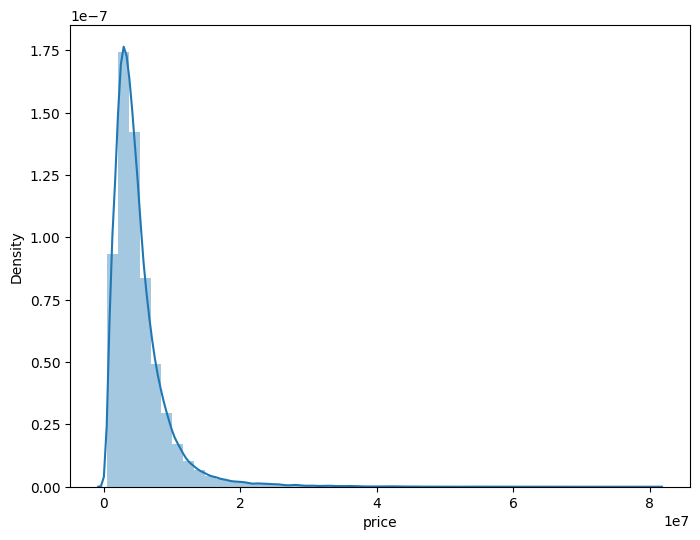

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# гистограмма
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot((y_train))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_scale=scaler.fit_transform(x_train)
x_scale_test=scaler.transform(x_test)


In [9]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
y_rf=rf.fit(x_train,y_train).predict(x_train)

print(1/(mean_absolute_error(y_train,y_rf)+1))

1.6230559279125868e-06


In [15]:
from lightgbm import LGBMRegressor

lgb_reg=LGBMRegressor()
lg_tr=lgb_reg.fit(x_train,y_train, eval_metric="MAE").predict(x_train)
print(1/(mean_absolute_error(y_train,lg_tr)+1))
lg_test=lgb_reg.predict(x_test)

#применение np.log1p(y_train) не дало улучшение скора

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 23
[LightGBM] [Info] Start training from score 5138395.940000
6.607448315770122e-07


In [11]:
from xgboost import XGBRegressor

xgb=XGBRegressor()
y_pred_xgb=xgb.fit(x_train,y_train).predict(x_train)
print(1/(mean_absolute_error(y_train,y_pred_xgb)+1))

7.672094252983987e-07


Пробуем RandomizedSearchCV

In [16]:
from sklearn.model_selection import RandomizedSearchCV
gridParams = {
    'num_leaves': [20,30,50,90,200],
    'boosting_type' : ['gbdt', 'reg'],
    'max_depth' : [5,6,7,8,9,10],
    'colsample_bytree' : [0.3,0.5,0.7],
    'subsample' : [0.3,0.5,0.7,0.9],
    'min_data_in_leaf':[5,8,10,15,20,25],
    'metric':['MAE']
    }
clf = LGBMRegressor()
grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
grid.fit(x_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1049, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 255, in train
    boos

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 23
[LightGBM] [Info] Start training from score 5138395.940000


RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'reg'],
                                        'colsample_bytree': [0.3, 0.5, 0.7],
                                        'max_depth': [5, 6, 7, 8, 9, 10],
                                        'metric': ['MAE'],
                                        'min_data_in_leaf': [5, 8, 10, 15, 20,
                                                             25],
                                        'num_leaves': [20, 30, 50, 90, 200],
                                        'subsample': [0.3, 0.5, 0.7, 0.9]},
                   verbose=1)

In [17]:
grid.best_params_

{'subsample': 0.5,
 'num_leaves': 30,
 'min_data_in_leaf': 15,
 'metric': 'MAE',
 'max_depth': 9,
 'colsample_bytree': 0.7,
 'boosting_type': 'gbdt'}

In [18]:
y_grid=grid.predict(x_train)
print(1/(mean_absolute_error(y_train,(y_grid))+1))

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
6.503889955898362e-07


Пробуем StackingCVRegressor( 8.495510786094605e-07 на x_train)

In [12]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor


gbr = GradientBoostingRegressor()
rf = RandomForestRegressor()
lgb=LGBMRegressor()
xgboost = XGBRegressor()

stack_gen = StackingCVRegressor(regressors=(xgboost, lgb, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

y_pred_tr=stack_gen.fit(x_train, y_train).predict(x_train)
print(1/(mean_absolute_error(y_train,(y_pred_tr))+1))
y_pred=stack_gen.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 22
[LightGBM] [Info] Start training from score 5143517.275000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 22
[LightGBM] [Info] Start training from score 5125699.850000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


8.495510786094605e-07


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Submit

In [ ]:
id=np.arange(100000,100000+x_test.shape[0])
submit=pd.DataFrame({"id":id, "price": y_pred})
submit.to_csv("ml_baseline.csv", index=False)

!cat ml_baseline.csv | head

id,price
100000,5120989.5
100001,5081475.0
100002,3438758.8
100003,4599949.0
100004,6820107.0
100005,5757268.0
100006,3841199.0
100007,2987665.0
100008,3163137.0
